# RTA workload

The RTA or RTApp workload represents a type of workload obtained using the rt-app test application.
More details on the test application can be found at https://github.com/scheduler-tools/rt-app.

In [2]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2017-08-16 17:44:55,450 INFO    : root         : Using LISA logging configuration:
2017-08-16 17:44:55,453 INFO    : root         :   /media/build/workspace/lisa-github/logging.conf


In [3]:
# Generate plots inline
%pylab inline

import json
import os

# Support to initialise and configure your test environment
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp, Step, Pulse

# Suport for FTrace events parsing and visualization
import trappy

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

Populating the interactive namespace from numpy and matplotlib


## Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

In [5]:
# Setup a target configuration
my_target_conf = {
    
#     # Define the kind of target platform to use for the experiments
#     "platform"    : 'linux',  # Linux system, valid other options are:
#                               # android - access via ADB
#                               # linux   - access via SSH
#                               # host    - direct access
    
#     # Preload settings for a specific target
#     "board"       : 'juno',  # juno - JUNO board with mainline hwmon
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/media/build/workspace/android-sdk",
    
    # Define devlib module to load
    "modules"     : [
        'bl',           # enable big.LITTLE support
        'cpufreq'       # enable CPUFreq support
    ],

    # Account to access the remote target
    "host"        : '192.168.0.1',
    "username"    : 'root',
    "password"    : 'juno',

    # Comment the following line to force rt-app calibration on your target
#     "rtapp-calib" : {
#         '0': 361, '1': 138, '2': 138, '3': 352, '4': 360, '5': 353
#     }
    "rtapp-calib" :
    {"0": 557, "1": 557, "2": 557, "3": 559, "4": 136, "5": 136, "6": 136, "7": 136}

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
            "cpu_frequency",
            "sched_load_avg_cpu",
            "sched_load_avg_task"
         ],
         "buffsize" : 10240
    },

}

In [6]:
# Initialize a test environment using
# - the provided target configuration (my_target_conf)
# - the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2017-08-16 17:45:18,717 INFO    : TestEnv      : Using base path: /media/build/workspace/lisa-github
2017-08-16 17:45:18,718 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-08-16 17:45:18,719 INFO    : TestEnv      : Loading custom (inline) test configuration
2017-08-16 17:45:18,720 INFO    : TestEnv      : External tools using:
2017-08-16 17:45:18,721 INFO    : TestEnv      :    ANDROID_HOME: /media/build/workspace/android-sdk
2017-08-16 17:45:18,722 INFO    : TestEnv      :    CATAPULT_HOME: /media/build/workspace/lisa-github/tools/catapult
2017-08-16 17:45:18,723 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2017-08-16 17:45:18,723 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2017-08-16 17:45:18,724 INFO    : TestEnv      : Connection settings:
2017-08-16 17:45:18,725 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2017-08-16 17:45:19,319 INFO    : TestEnv      : Initializing target workdi

## Workload configuration

To create an instance of an RTApp workload generator you need to provide the following:
- target: target device configuration
- name: name of workload. This is the name of the JSON configuration file reporting the generated RTApp configuration.
- calibration: CPU load calibration values, measured on each core.

An RTApp workload is defined by specifying a **kind**, provided below through **rtapp.conf**, which represents the way we want to define the behavior of each task.
The possible kinds of workloads are **profile** and **custom**. It's very important to notice that **periodic** is no longer considered a "kind" of workload but a "class" within the **profile** kind.
<br><br>
As you see below, when "kind" is "profile", the tasks generated by this workload have a profile which is defined by a sequence of phases. These phases are defined according to the following grammar:<br>
 - params := {task, ...} <br>
 - task   := NAME : {SCLASS, PRIO, [phase, ...]}<br>
 - phase  := (PTIME, PERIOD, DCYCLE)<br> <br>
 
There are some pre-defined task classes for the **profile** kind:
 - **Step**: the load of this task is a step with a configured initial and final load. 
 - **Pulse**: the load of this task is a pulse with a configured initial and final load.The main difference with the 'step' class is that a pulse workload is by definition a 'step down', i.e. the workload switches from an initial load to a final one which is always lower than the initial one. Moreover, a pulse load does not generate a sleep phase in case of 0[%] load, i.e. the task ends as soon as the non null initial load has completed.
 - **Ramp**: the load of this task is a ramp with a configured number of steps determined by the input parameters.
 - **Periodic**: the load of this task is periodic with a configured period and duty-cycle.<br><br>
The one below is a workload mix having all types of workloads described above, but each of them can also be specified serapately in the RTApp parameters. 

In [12]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per20': Periodic(
            period_ms=5,         # period
            duty_cycle_pct=100,     # duty cycle
            duration_s=2,          # duration
            cpus="4",             # run on all CPUS
#             sched={
#                 "policy": "FIFO",  # Run this task as a SCHED_FIFO task
#             },
            delay_s=1              # start at the start of RTApp
        ).get(),

        # 4. RAMP task
        #
        # This class defines a task which load is a ramp with a configured number
        # of steps according to the input parameters.
        # 
        # Args:
        #     start_pct (int, [0-100]): the initial load [%], (default 0[%])
        #     end_pct   (int, [0-100]): the final load [%], (default 100[%])
        #     delta_pct (int, [0-100]): the load increase/decrease [%],
        #                               default: 10[%]
        #                               increase if start_prc < end_prc
        #                               decrease  if start_prc > end_prc
        #     time_s    (float): the duration in [s] of each load step
        #                        default: 1.0[s]
        #     period_ms (float): the period used to define the load in [ms]
        #                        default: 100.0[ms]
        #     delay_s   (float): the delay in [s] before ramp start
        #                        default: 0[s]
        #     loops     (int):   number of time to repeat the ramp, with the
        #                        specified delay in between
        #                        default: 0
        #     sched     (dict): the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
#         'task_rmp20': Ramp(
#             period_ms=100,         # period
#             start_pct=10,           # intial load
#             end_pct=100,            # end load
#             delta_pct=20,          # load % increase...
#             time_s=1,              # ... every 1[s]
#             delay_s=1,
#             cpus="1"               # run just on first CPU
#         ).get(),
        
        # 5. STEP task
        # 
        # This class defines a task which load is a step with a configured
        # initial and final load.
        # 
        # Args:
        # start_pct (int, [0-100]): the initial load [%]
        #                               default 0[%])
        # end_pct   (int, [0-100]): the final load [%]
        #                               default 100[%]
        # time_s    (float): the duration in [s] of the start and end load
        #                        default: 1.0[s]
        # period_ms (float): the period used to define the load in [ms]
        #                        default 100.0[ms]
        # delay_s   (float): the delay in [s] before ramp start
        #                        default 0[s]
        # loops     (int):   number of time to repeat the ramp, with the
        #                        specified delay in between
        #                        default: 0
        # sched     (dict): the scheduler configuration for this task
        # cpus      (list): the list of CPUs on which task can run
#         'task_stp10-50': Step(
#             period_ms=100,         # period
#             start_pct=0,           # intial load
#             end_pct=50,            # end load
#             time_s=1,              # ... every 1[s]
#             delay_s=0.5            # start .5[s] after the start of RTApp
#         ).get(),
        
        # 6. PULSE task
        #
        # This class defines a task which load is a pulse with a configured
        # initial and final load.
        # 
        # The main difference with the 'step' class is that a pulse workload is
        # by definition a 'step down', i.e. the workload switch from an finial
        # load to a final one which is always lower than the initial one.
        # Moreover, a pulse load does not generate a sleep phase in case of 0[%]
        # load, i.e. the task ends as soon as the non null initial load has
        # completed.
        # 
        # Args:
        #     start_pct (int, [0-100]): the initial load [%]
        #                               default: 0[%]
        #     end_pct   (int, [0-100]): the final load [%]
        #                               default: 100[%]
        #               NOTE: must be lower than start_pct value
        #     time_s    (float): the duration in [s] of the start and end load
        #                        default: 1.0[s]
        #                        NOTE: if end_pct is 0, the task end after the
        #                        start_pct period completed
        #     period_ms (float): the period used to define the load in [ms]
        #                        default: 100.0[ms]
        #     delay_s   (float): the delay in [s] before ramp start
        #                        default: 0[s]
        #     loops     (int):   number of time to repeat the ramp, with the
        #                        specified delay in between
        #                        default: 0
        #     sched     (dict):  the scheduler configuration for this task
        #     cpus      (list):  the list of CPUs on which task can run
#         'task_pls5-80': Pulse(
#             period_ms=100,         # period
#             start_pct=65,          # intial load
#             end_pct=5,             # end load
#             time_s=1,              # ... every 1[s]
#             delay_s=0.5            # start .5[s] after the start of RTApp
#         ).get(),
        
        
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2017-08-16 17:48:48,145 INFO    : Workload     : Setup new workload simple
2017-08-16 17:48:48,218 INFO    : Workload     : Workload duration defined by longest task
2017-08-16 17:48:48,220 INFO    : Workload     : Default policy: SCHED_OTHER
2017-08-16 17:48:48,222 INFO    : Workload     : ------------------------
2017-08-16 17:48:48,223 INFO    : Workload     : task [task_per20], sched: using default policy
2017-08-16 17:48:48,224 INFO    : Workload     :  | start delay: 1.000000 [s]
2017-08-16 17:48:48,225 INFO    : Workload     :  | loops count: 1
2017-08-16 17:48:48,226 INFO    : Workload     :  | CPUs affinity: 4
2017-08-16 17:48:48,226 INFO    : Workload     :  + phase_000001: batch 2.000000 [s]


The output of the previous cell reports the main properties of the generated
tasks. Thus for example we see that the first task is configure to be:
 - named **task_per20**
 - executed as a **SCHED_FIFO** task
 - generating a load which is **calibrated** with respect to the **CPU 1**
 - with one single "phase" which defines a peripodic load for the **duration** of **5[s]**
 - that periodic load consistes of **50 cycles**
 - each cycle has a **period** of **100[ms]** and a **duty-cycle** of **20%**,
   which means that the task, for every cycle, will **run** for **20[ms]** and then sleep for **80[ms]** 

All these properties are translated into a JSON configuration file for RTApp which you can see in **Collected results** below.<br>

## Workload execution

In [13]:
logging.info('#### Setup FTrace')
te.ftrace.start()

# logging.info('#### Start energy sampling')
# te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

# logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
# nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2017-08-16 17:48:57,026 INFO    : root         : #### Setup FTrace
2017-08-16 17:48:59,316 INFO    : root         : #### Start RTApp execution
2017-08-16 17:48:59,319 INFO    : Workload     : Workload execution START:
2017-08-16 17:48:59,330 INFO    : Workload     :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1


2017-08-16 17:49:02,808 INFO    : root         : #### Stop FTrace
2017-08-16 17:49:02,988 INFO    : root         : #### Save FTrace: /media/build/workspace/lisa-github/results/20170816_174518/trace.dat
2017-08-16 17:49:04,921 INFO    : root         : #### Save platform description: /media/build/workspace/lisa-github/results/20170816_174518/platform.json


## Collected results

In [14]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
print json.dumps(rtapp_json, indent=4, sort_keys=True)

2017-08-16 17:49:04,944 INFO    : root         : Generated RTApp JSON file:


{
    "global": {
        "calibration": 136, 
        "default_policy": "SCHED_OTHER", 
        "duration": -1, 
        "logdir": "/data/local/tmp/devlib-target"
    }, 
    "tasks": {
        "task_per20": {
            "cpus": [
                4
            ], 
            "delay": 1000000, 
            "loop": 1, 
            "phases": {
                "p000001": {
                    "loop": 1, 
                    "run": 2000000
                }
            }, 
            "policy": "SCHED_OTHER"
        }
    }
}


In [8]:
# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

2017-08-16 14:35:39,049 INFO    : root         : Content of the output folder /media/build/workspace/lisa-github/results/20170816_143441


total 6380
drwxrwxr-x  2 steven steven    4096 Aug 16 14:35 .
drwxrwxr-x 51 steven steven    4096 Aug 16 14:34 ..
-rw-rw-r--  1 steven steven     307 Aug 16 14:35 output.log
-rw-rw-r--  1 steven steven    1518 Aug 16 14:35 platform.json
-rw-r--r--  1 steven steven     284 Aug 16 14:35 rt-app-task_per20-0.log
-rw-r--r--  1 steven steven    6360 Aug 16 14:35 rt-app-task_rmp20-1.log
-rw-r--r--  1 steven steven    2002 Aug 16 14:35 simple_00.json
-rw-r--r--  1 steven steven 6500352 Aug 16 14:35 trace.dat


## Trace inspection


More information on visualization and trace inspection can be found in **examples/trappy**.

In [33]:
my_events = [
    "sched_load_avg_cpu",
    "sched_load_avg_task",
    "cpu_frequency",
    "cpu_capacity"
]
# trace_file = "/media/build/workspace/lisa-github/results_latest/" + 'trace.dat'
trace_file = os.path.join(te.res_dir, 'trace.dat')
# !kernelshark {trace_file} 2>/dev/null


import trappy

ftrace = trappy.FTrace(
    name="PandasExamples",
    path=trace_file,
    scope='custom',
    events=my_events,
    window=(0,None))


my_signals = [
     'sched_load_avg_task:util_avg',
        'sched_load_avg_task:load_avg'

     #'sched_load_avg_cpu:util_cpu'
]



# These two paramatere are passed to the LinePlot call as long with the
# TRAPpy FTrace object
trappy.ILinePlot(
    
    # FTrace object
    ftrace,
    
    # Signals to be plotted
    signals=my_signals,
    
    # Generate one plot for each value of the specified column
    pivot='pid',
    
    # Generate only plots which satisfy these filters
    filters = {
       'comm' : 'task_per20'
    
    },
    # Formatting style
    drawstyle='steps-post',
    marker = '+', xlim=(1,2)
).view()


""
""


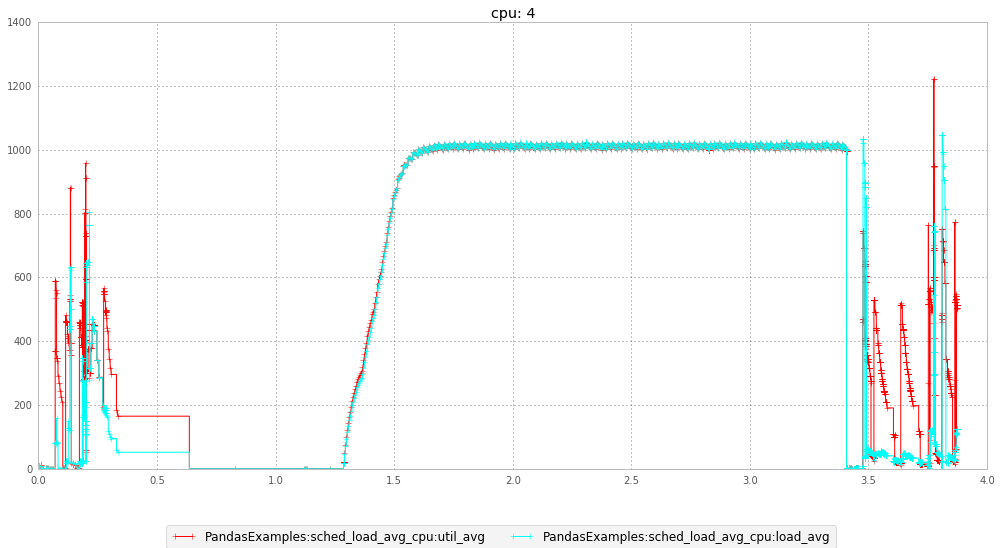

In [35]:

my_signals1 = [

         'sched_load_avg_cpu:util_cpu'
]
trappy.LinePlot(
    
    # FTrace object
    ftrace,
    
    # Signals to be plotted
    signals=[
    "sched_load_avg_cpu:util_avg",
    "sched_load_avg_cpu:load_avg",
   # 'cpu_frequency:frequency',
        
    ],
    
    # Generate one plot for each value of the specified column
    pivot='cpu',
    
    # Generate only plots which satisfy these filters
    filters = {
       'cpu' : [ 4 ]
    
    },
    # Formatting style
    drawstyle='steps-post',
    marker = '+'
).view()

In [16]:
df = ftrace.sched_load_avg_task.data_frame
df.head(2)
# select = (df.comm == 'task_per20')
# df.loc[:,'d'] = df.index
# df.loc[:,'c'] = df['d'].shift()
# df.loc[:,'e'] = (df['d'] - df['c']).fillna(0)
# print df.index.min(), df.index.max()
df.index = df.index*1000
l=trappy.ILinePlot(
    
    # FTrace object
    ftrace,
    
    # Signals to be plotted
    signals=my_signals,
    
    # Generate one plot for each value of the specified column
    pivot='pid',
    
    # Generate only plots which satisfy these filters
    filters = {
       'comm' : 'task_per20'
    
    },
    # Formatting style
    drawstyle='steps-post',
    marker = '+', ylim=(0,1100)
)
l.view()

""
""


In [10]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file

trappy.plotter.plot_trace(te.res_dir)

/media/build/workspace/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.SchedContribScaleFactor object at 0x7fed9db47990> from cache, reading it from trace
  warnings.warn(warnstr)
/media/build/workspace/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.cpu_power.CpuOutPower object at 0x7fed9db47050> from cache, reading it from trace
  warnings.warn(warnstr)
/media/build/workspace/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.sched.SchedLoadAvgSchedGroup object at 0x7fed9db47550> from cache, reading it from trace
  warnings.warn(warnstr)
/media/build/workspace/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.pid_controller.PIDController object at 0x7fed9db47710> from cache, reading it from trace
  warnings.warn(warnstr)
/media/build/workspace/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't r

IndexError: index 0 is out of bounds for axis 0 with size 0

## RTApp task performance plots

2017-08-01 14:50:15,369 INFO    : PerfAnalysis : PerfIndex, Task [task_rmp20_5-60] avg: 0.46, std: 0.44
2017-08-01 14:50:16,041 INFO    : PerfAnalysis : PerfIndex, Task [task_rmp20] avg: -4.55, std: 6.58


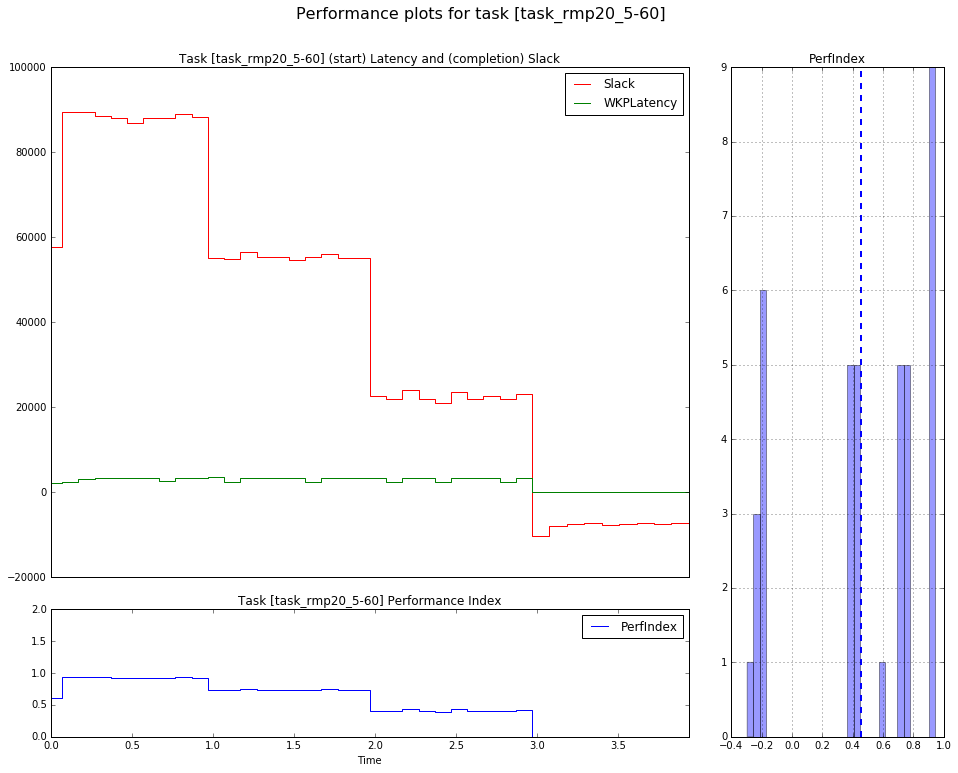

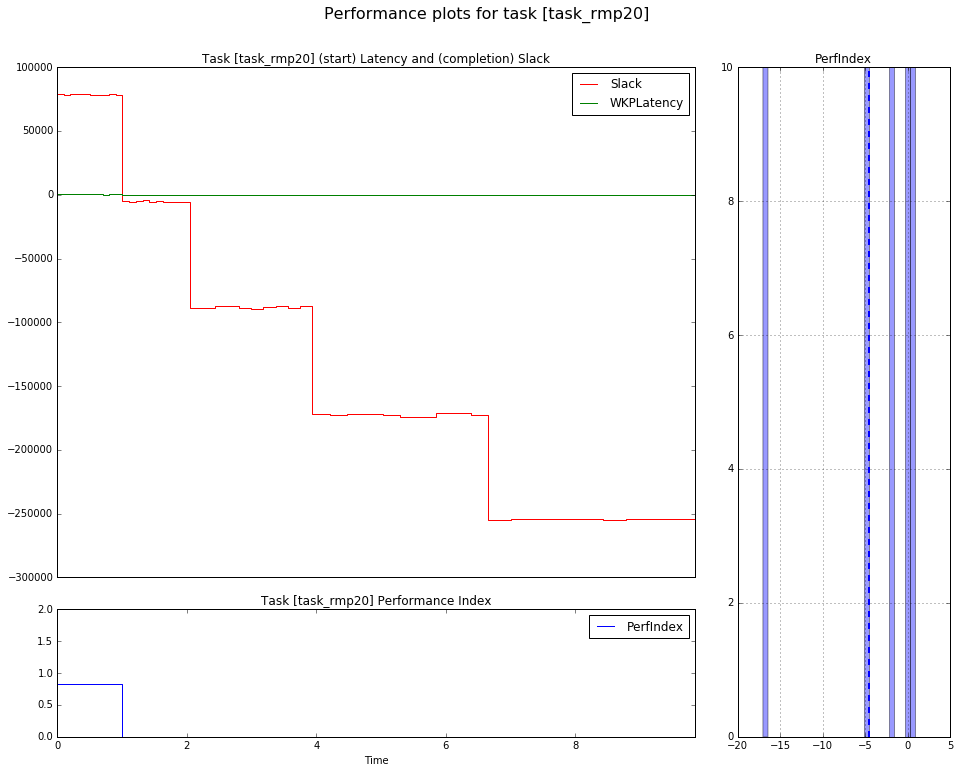

In [11]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))